In [1]:
import dynalearn as dl
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import os

In [2]:
degree = 5
n_nodes = 100
rate = 0.8
T = 8
dt = 0.001
fprefix = 'data/rrg_sis_'
train_sample = 50000
val_sample = 1000


In [3]:
# Generating the network
graph = nx.random_regular_graph(degree, n_nodes)
nx.write_edgelist(graph, fprefix + 'edgelist.b')
    
# Generating the time series
continue_simu = False
iter_max = 100
i = 0



#if os.path.exists(fprefix + '_states.b'):
#    os.remove(fprefix + '_states.b')
data = {}
idx = 0
while(i < train_sample):
    data[idx] = []
    sisnet = dl.dynamics.SISNetwork(graph, rate, dt=dt, filename=None,
                                    full_data_mode=True, overwrite=True)
    t = 0
    while(t < T and sisnet.continue_simu and i < train_sample):
        t += dt
        sisnet.update(record=False)
        i += 1
        data[idx].append(sisnet.activity)
    idx += 1

f = open(fprefix + 'states.b', 'wb')
pickle.dump(data, f)
f.close()

%reset_selective -f data

In [4]:
transform = [dl.SIS_StateToFloat(), dl.ResizeData((n_nodes, 1))]

dataset = dl.Markov_Dataset(fprefix + 'states.b', pre_transform=transform)

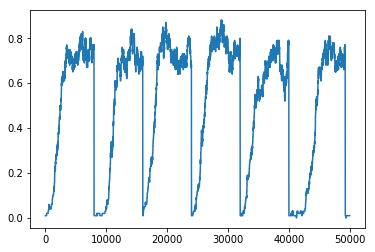

In [5]:
def show_train_dataset(dataset):
    avg = []
    for i in range(len(dataset)):
        x = dataset[i][0].numpy()
        avg.append(np.mean(x))
    return avg
avg = show_train_dataset(dataset)
plt.plot(avg)
plt.show()

In [7]:
n_hidden = [64, 16]
n_embedding = 2
optimizer = lambda p: torch.optim.Adam(p, lr=1e-3)
use_cuda = False
loss = torch.nn.BCELoss(reduction='sum')



markov_cvae = dl.Markov_Node_CVAE(graph, n_hidden, n_embedding, optimizer=optimizer, loss=loss, use_cuda=use_cuda)

In [8]:
new_lr = 1e-3
for g in markov_cvae.optimizer.param_groups:
    g['lr'] = new_lr

In [9]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [len(dataset) - val_sample, val_sample])
markov_cvae.fit(train_dataset, val_dataset, epochs=10, batch_size=128)

Epoch: 0 - Time: 0.00
	 Training - Loss: 507.3828 ± 0.07, Recon.: 69.3365 ± 0.04, KL-div.: 438.0462 ± 0.05
	 Validation - Loss: 507.3718 ± 0.05, Recon.: 69.3476 ± 0.03, KL-div.: 438.0243 ± 0.04
New best epoch: 1 - Time: 749.53
	 Training - Loss: 0.8810 ± 0.18, Recon.: 0.8805 ± 0.18, KL-div.: 0.0005 ± 0.00
	 Validation - Loss: 0.9110 ± 0.24, Recon.: 0.9105 ± 0.24, KL-div.: 0.0005 ± 0.00


KeyboardInterrupt: 

In [10]:
def test_model(learned_model, dataset):
    init_states = dataset[0][1]

    t = 0
    states, z, past_states = learned_model.predict(init_states, batch_size=2)    
    learned_avg = [np.mean(states)]
    
    while(t < T):
        t += dt
        states, z, past_states = learned_model.predict(past_states, batch_size=2)

        learned_avg.append(np.mean(states))
        states = torch.bernoulli(torch.tensor(states[0]))
        past_states = states
    
    return learned_avg

def show_train_dataset(dataset):
    avg = []
    for i in range(len(dataset)):
        x = dataset[i][0].numpy()
        avg.append(np.mean(x))
    return avg

def show_dataset(dataset):
    avg = []
    t = 0
    sisnet = dl.dynamics.SISNetwork(graph, rate, dt=dt,
                                    filename=None,
                                    full_data_mode=False,
                                    overwrite=True)
    while t < T:
        t += dt
        sisnet.update(record=False)
        avg_state, std_state = sisnet.get_avg_activity()
        avg.append(avg_state['I'])
    return avg


In [11]:
null_cvae = dl.Markov_Node_CVAE(graph, n_hidden, n_embedding, optimizer=optimizer, loss=loss, use_cuda=use_cuda)

avg_ts = show_dataset(dataset)
trained_ts = test_model(markov_cvae, dataset)
untrained_ts = test_model(null_cvae, dataset)

#avg_ts = show_train_dataset(dataset)


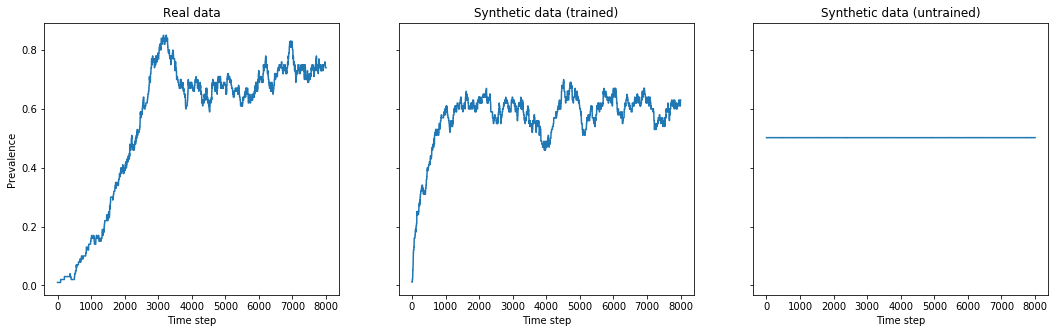

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharex=True,sharey=True)

ax[0].plot(avg_ts)
ax[0].set_title('Real data')
ax[0].set_ylabel('Prevalence')
ax[0].set_xlabel('Time step')

ax[1].plot(trained_ts)
ax[1].set_title('Synthetic data (trained)')
ax[1].set_xlabel('Time step')

ax[2].plot(untrained_ts)
ax[2].set_title('Synthetic data (untrained)')
ax[2].set_xlabel('Time step')

#fig.savefig('fig/png/nodemodel_test_rrgsis_d5_n100_rate0.4.png')
#fig.savefig('fig/pdf/nodemodel_test_rrgsis_d5_n100_rate0.4.pdf')
plt.show()

In [27]:
def reconstruction_dataset(model, dataset):
    learned = np.zeros(len(dataset))
    real = np.zeros(len(dataset))
    
    for i, d in enumerate(dataset):
        
        if i%1000==0: print(str(i) + "/" + str(len(dataset)))
        present, past = d
        sample, _, _ = model.predict(past, batch_size=2)
        learned[i] = np.mean(sample)
        real[i] = np.mean(present.numpy())
        
    return real, learned
        
    

In [28]:
real, learned = reconstruction_dataset(markov_cvae, dataset)

0/49991
1000/49991
2000/49991
3000/49991
4000/49991
5000/49991
6000/49991
7000/49991
8000/49991
9000/49991
10000/49991
11000/49991
12000/49991
13000/49991
14000/49991
15000/49991
16000/49991
17000/49991
18000/49991
19000/49991
20000/49991
21000/49991
22000/49991
23000/49991
24000/49991
25000/49991
26000/49991
27000/49991
28000/49991
29000/49991
30000/49991
31000/49991
32000/49991
33000/49991
34000/49991
35000/49991
36000/49991
37000/49991
38000/49991
39000/49991
40000/49991
41000/49991
42000/49991
43000/49991
44000/49991
45000/49991
46000/49991
47000/49991
48000/49991
49000/49991


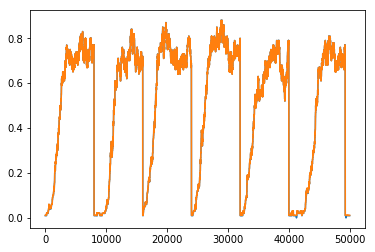

In [29]:
plt.plot(real)
plt.plot(learned)
plt.show()
